In [105]:
import copy
import logging
import os
import sys

import pandas as pd
import numpy as np
import datetime as dt
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import cm

sys.path.append('..\..')

from data_pipeline_api import standard_api

from simple_network_sim import network_of_populations as ss, loaders
from simple_network_sim.sampleUseOfModel import runSimulation, aggregateResults

def formatter(x, pos):
    if x == 0.:
        return "0"
    elif x < 1e3:
        return f"{x:,.0f}"
    elif x < 1e4:
        return f"{x / 1e3:,.1f}k"
    else:
        return f"{x / 1e3:,.0f}k"

fmt = ticker.FuncFormatter(lambda x, pos: formatter(x, pos))

loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
    logger.setLevel(logging.ERROR)

In [162]:
def aggregate_all_boards(results):
    return results[0].output.groupby(["date", "state"]).sum().reset_index().pivot(index="date", columns="state", values="total")


def bump_compartment_transition(compartment_1, compartment_2, bump, age):
    progression_bumped = copy.deepcopy(api.read_table("human/compartment-transition", "compartment-transition"))
    progression_bumped = progression_bumped.set_index(["age", "src", "dst"]).sort_index()

    diff = np.clip(bump + progression_bumped.loc[(age, compartment_1, compartment_2)], 0., 1.) - progression_bumped.loc[(age, compartment_1, compartment_2)]
    progression_bumped.loc[(age, compartment_1, compartment_2)] += diff

    total = 0.
    for compartment_to_adjust in progression_bumped.loc[(age, compartment_1)].index:
        if compartment_to_adjust != compartment_2:
            progression_bumped.loc[(age, compartment_1, compartment_to_adjust)] -= diff / (len(progression_bumped.loc[(age, compartment_1)]) - 1)
            progression_bumped.loc[(age, compartment_1, compartment_to_adjust)] = np.clip(progression_bumped.loc[(age, compartment_1, compartment_to_adjust)], 0., 1.)

        total += progression_bumped.loc[(age, compartment_1, compartment_to_adjust)]
    progression_bumped.loc[(age, compartment_1, compartment_2)] += 1. - total
            
    return progression_bumped.reset_index()


def bump_infection_matrix(age_range1, age_range2, bump):
    infectionMatrix_bumped = api.read_table("human/mixing-matrix", "mixing-matrix").set_index(["source", "target"])
    infectionMatrix_bumped.loc[(str(age_range1), str(age_range2))] = np.maximum(0., infectionMatrix_bumped.loc[(str(age_range1), str(age_range2))] + bump)
            
    return infectionMatrix_bumped.reset_index()


def bump_movement_multipliers(movement_bump, contact_bump, time_min=dt.date(2020, 3, 9), time_max=dt.date(2080, 3, 9)):
    movementMultipliers_bumped = api.read_table("human/movement-multipliers", "movement-multipliers")
    movementMultipliers_bumped.Date = pd.to_datetime(movementMultipliers_bumped.Date).dt.date

    movementMultipliers_bumped.loc[(movementMultipliers_bumped.Date >= time_min) & (movementMultipliers_bumped.Date <= time_max), "Movement_Multiplier"] = \
    np.maximum(movementMultipliers_bumped.loc[(movementMultipliers_bumped.Date >= time_min) & (movementMultipliers_bumped.Date <= time_max), "Movement_Multiplier"] + movement_bump, 0.)
    
    movementMultipliers_bumped.loc[(movementMultipliers_bumped.Date >= time_min) & (movementMultipliers_bumped.Date <= time_max), "Contact_Multiplier"] = \
    np.maximum(movementMultipliers_bumped.loc[(movementMultipliers_bumped.Date >= time_min) & (movementMultipliers_bumped.Date <= time_max), "Contact_Multiplier"] + contact_bump, 0.)

    movementMultipliers_bumped.Date = movementMultipliers_bumped.Date.astype(str)
    
    return movementMultipliers_bumped


def create_network(compartment_transition=None, population=None, commutes=None, mixing_matrix=None, infectious_compartments=None, infection_probability=None, movement_multipliers=None):    
    with standard_api.StandardAPI.from_config("../../config_inference.yaml", uri="", git_sha="") as store:
        network, _ = ss.createNetworkOfPopulation(
            store.read_table("human/compartment-transition", "compartment-transition") if compartment_transition is None else compartment_transition,
            store.read_table("human/population", "population") if population is None else population,
            store.read_table("human/commutes", "commutes") if commutes is None else commutes,
            store.read_table("human/mixing-matrix", "mixing-matrix") if mixing_matrix is None else mixing_matrix,
            store.read_table("human/infectious-compartments", "infectious-compartments") if infectious_compartments is None else infectious_compartments,
            store.read_table("human/infection-probability", "infection-probability") if infection_probability is None else infection_probability,
            store.read_table("human/initial-infections", "initial-infections"),
            store.read_table("human/trials", "trials"),
            store.read_table("human/start-end-date", "start-end-date"),
            store.read_table("human/movement-multipliers", "movement-multipliers") if movement_multipliers is None else movement_multipliers,
            store.read_table("human/stochastic-mode", "stochastic-mode"),
        )
        
    return network

As a starting point we use a set of realistic (yet not final) parameters for disease evolution, provided by Jessica Enright.

In [70]:
api = standard_api.StandardAPI.from_config("../../config_inference.yaml", uri="", git_sha="")
random_seed = loaders.readRandomSeed(api.read_table("human/random-seed", "random-seed"))
network = create_network()

# 1) Parameters description

### a) Compartment transitions

Compartment transition describe the probability of each individual in each of the seven disease states (Exposed, Asymptomatic, Infectious, Recovered, Dead, Hosplitalized) to progress to next level of the disease.

In [12]:
df = api.read_table("human/compartment-transition", "compartment-transition")

pd.pivot_table(df, values="rate", index="dst", columns=["age", "src"]).style.set_precision(2).background_gradient("Reds", high=0.5).highlight_null("black")

### b) Movement and contact multipliers

These multipliers are applied to movement and contact and allow dampening of the transmission to account for quarantine, people behaving safer, etc.

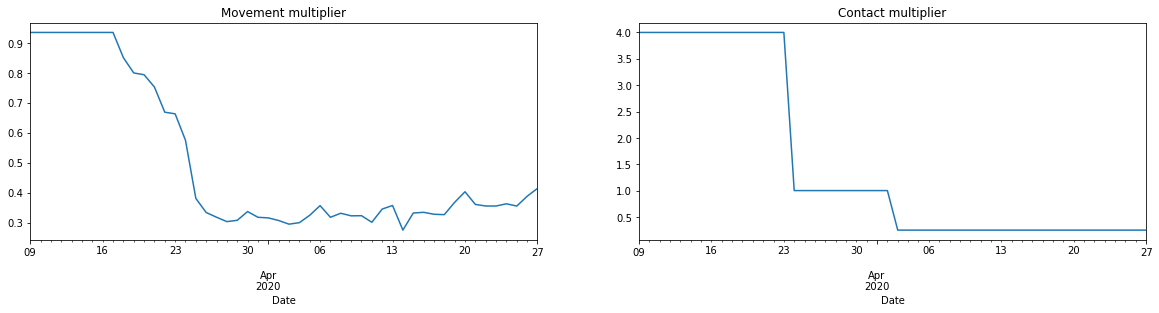

In [24]:
movement_multipliers = api.read_table("human/movement-multipliers", "movement-multipliers")
movement_multipliers.Date = pd.to_datetime(movement_multipliers.Date)
movement_multipliers.set_index("Date", inplace=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
movement_multipliers.Movement_Multiplier.plot(ax=axes[0], title="Movement multiplier")
movement_multipliers.Contact_Multiplier.plot(ax=axes[1], title="Contact multiplier");

### c) Infection matrix

The infection matrix stores the expected numbers of interactions between people of different ages. Each of these interactions leads to an infection. Several interactions can target the same person.

In [25]:
df = api.read_table("human/mixing-matrix", "mixing-matrix")
pd.pivot_table(df, values="mixing", index="source", columns="target").style.set_precision(2).background_gradient("Reds", high=0.5)

target,70+,"[0,17)","[17,70)"
source,,,
70+,0.37,0.15,0.97
"[0,17)",0.10,1.97,1.76
"[17,70)",0.19,0.54,1.54


### d) Population

The initial population per scottish health board (an health board is broadly a large region/county of scotland). There are 14 in total, for a global population of 5.4mm individuals.

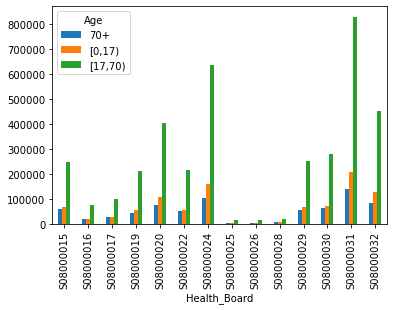

In [28]:
df = api.read_table("human/population", "population")
pd.pivot_table(df, values="Total", index="Health_Board", columns="Age", aggfunc="sum").plot.bar();

### e) Initial infections

Initial infections represent the number of infected people at the beginning of the crisis, per health board, as of 15 March 2020.

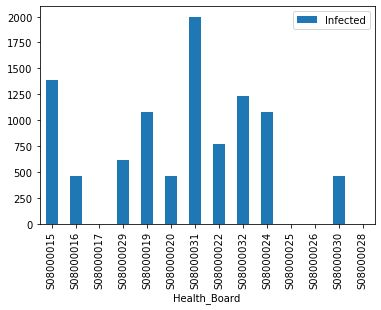

In [38]:
initial_infections = api.read_table("human/initial-infections", "initial-infections")
initial_infections.set_index("Health_Board").plot.bar();

# 2) Parameter sensitivity analysis

### a) Baseline run

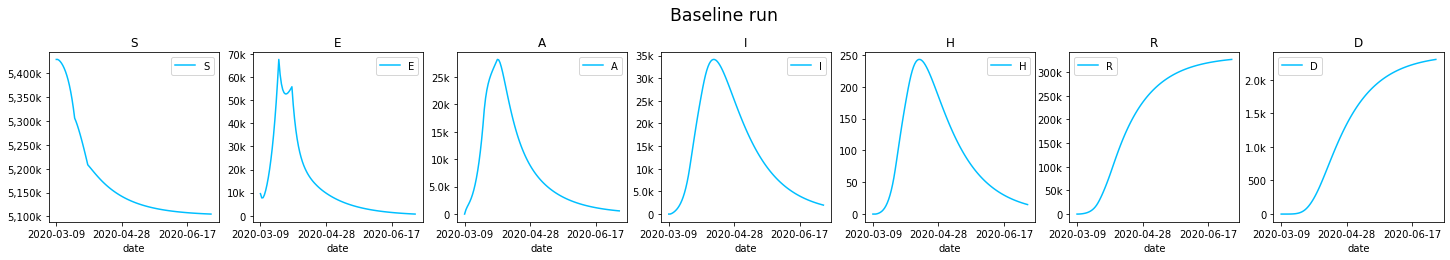

In [57]:
res = runSimulation(network, random_seed, [])
res = aggregate_all_boards(res)

fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(25, 3.5), sharex=True)
fig.suptitle(f"Baseline run", fontsize='xx-large')
fig.subplots_adjust(top=0.8)
for i, col in enumerate(['S', 'E', 'A', 'I', 'H', 'R', 'D']):
    res[col].plot(ax=axes[i], title=col, c="deepskyblue")
    axes[i].legend()
    axes[i].yaxis.set_major_formatter(fmt)

### b) Sensitivity to compartment transition matrix probabilities

We notice that the most impactful parameters are the transmission probabilities from the asymptomatic class. Both the probabilities starting from exposed, infectious and hospitalized, while having an impact, have a more marginal one.

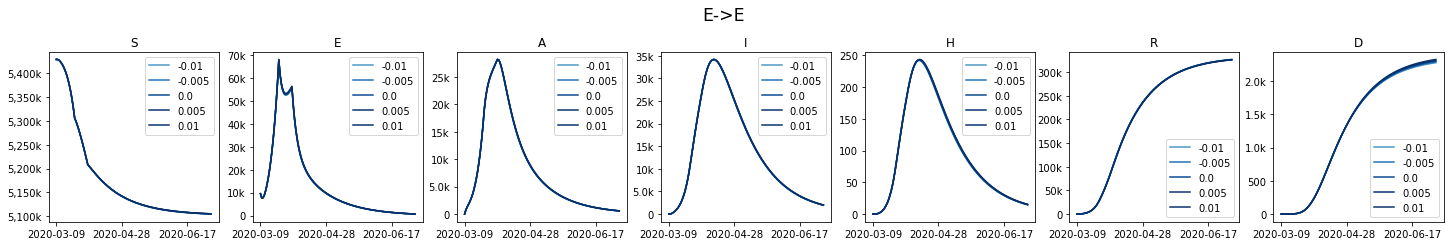

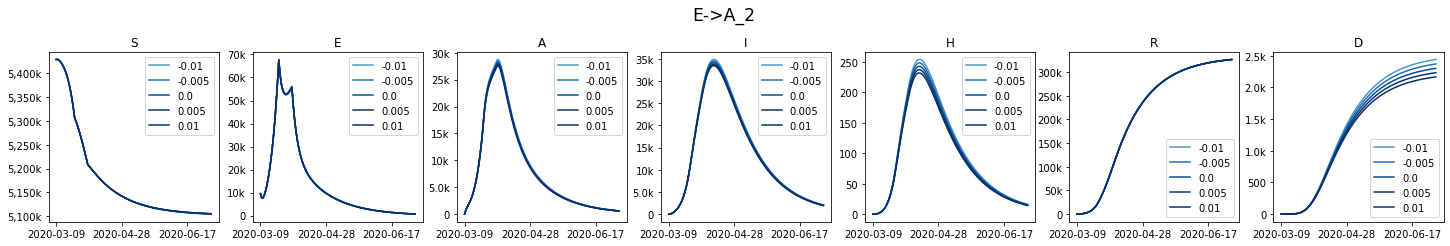

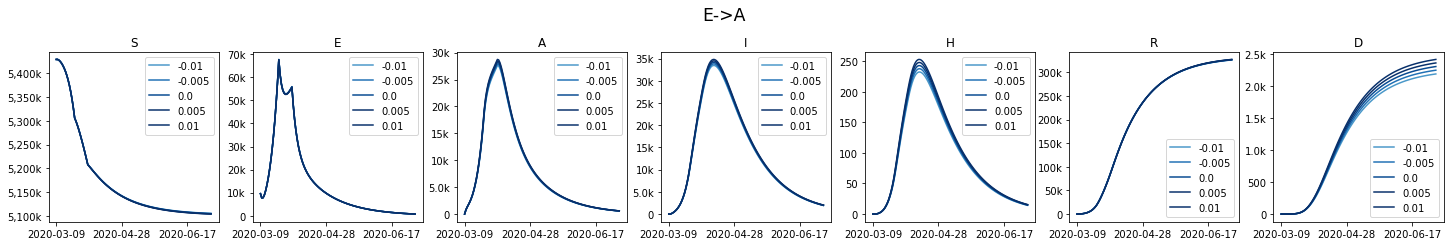

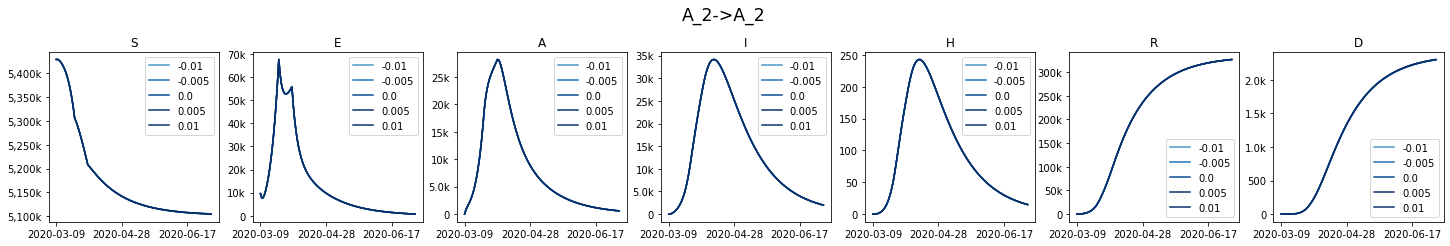

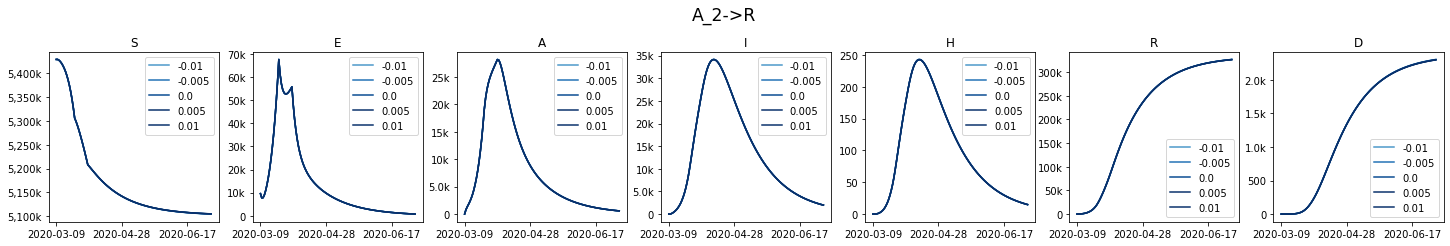

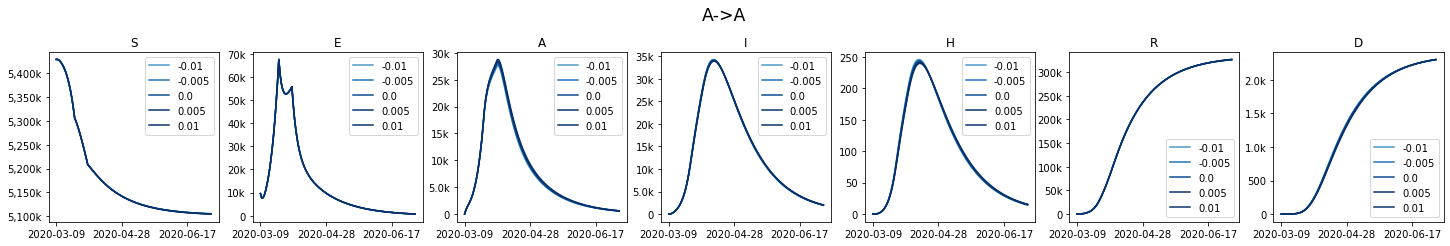

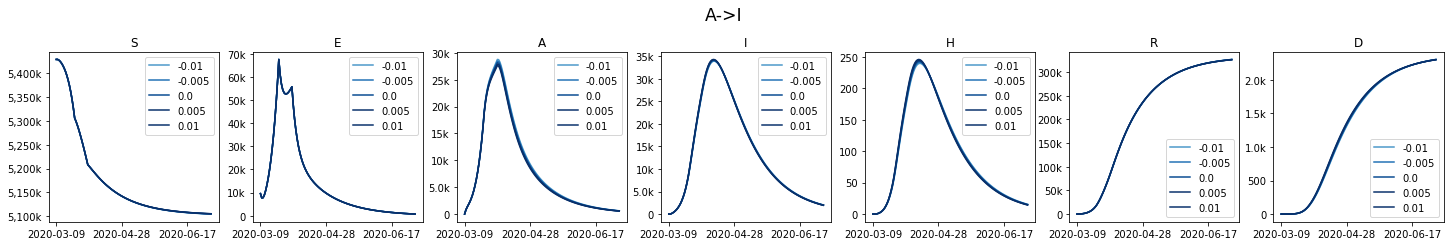

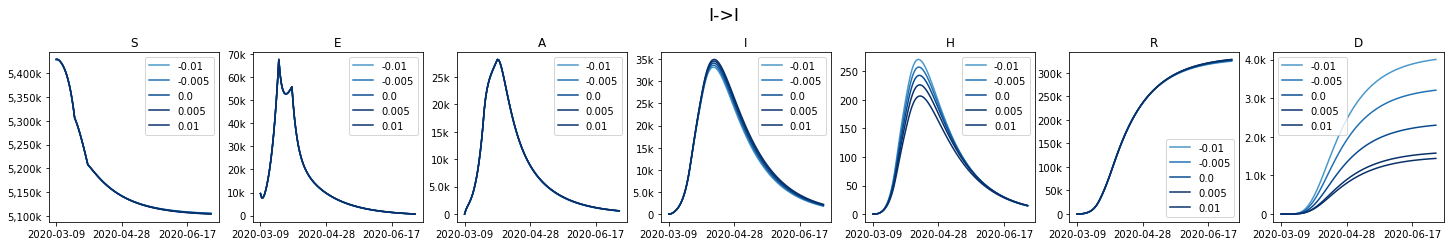

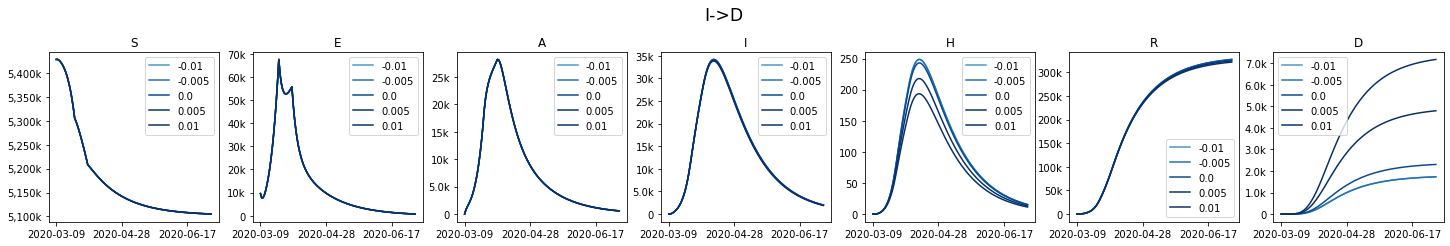

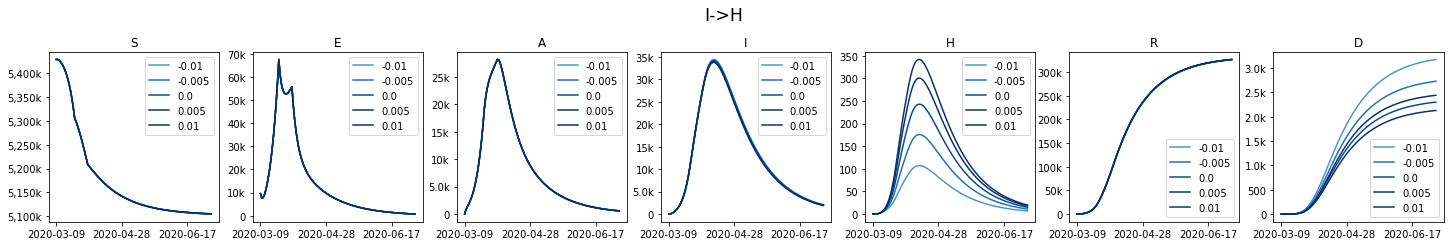

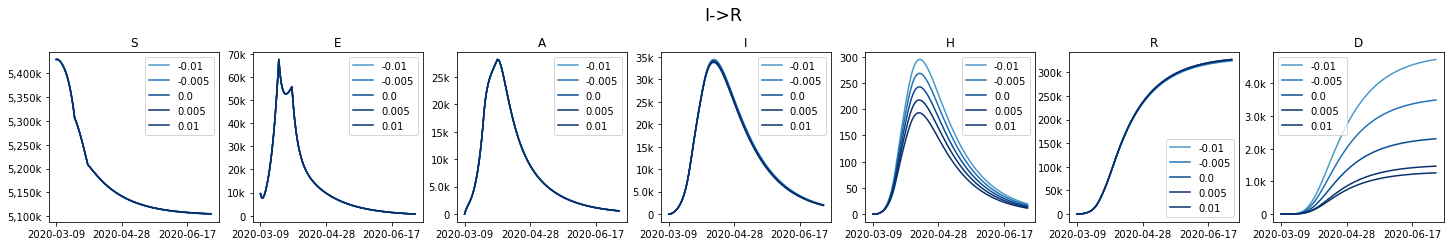

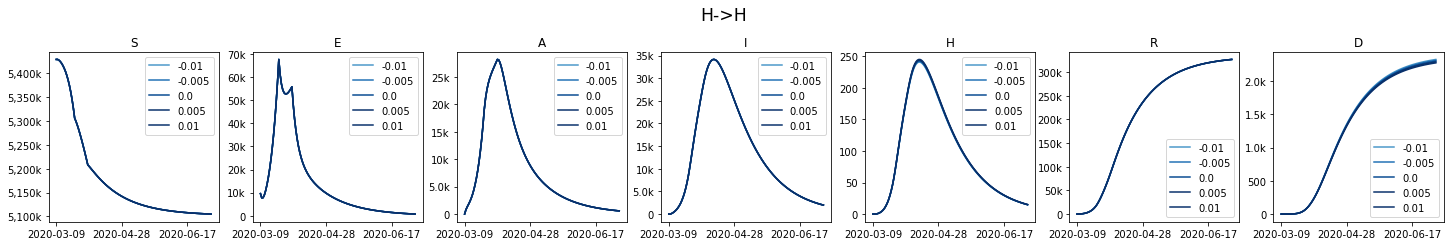

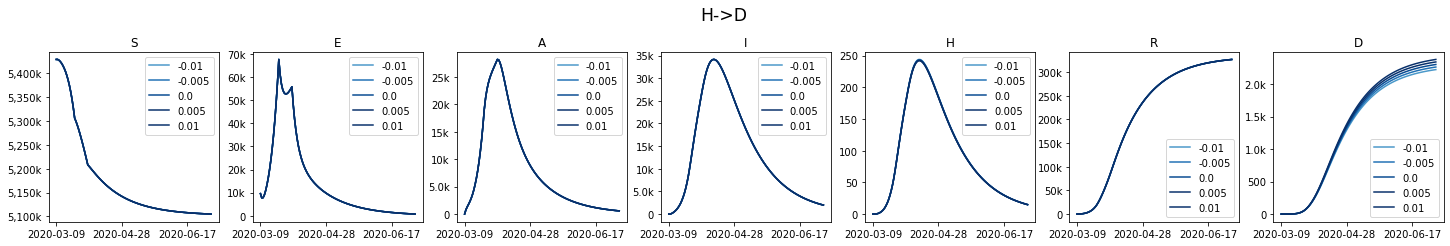

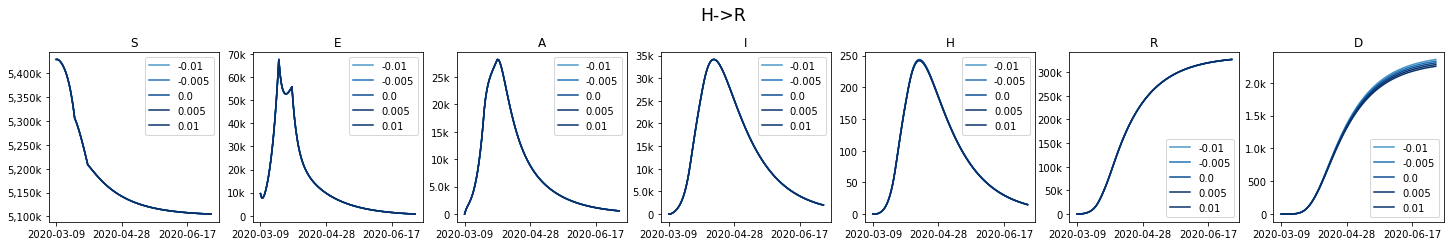

In [163]:
age = '70+'
for compartment_1, values in network.progression[age].items():
    for compartment_2, proba in values.items():

        if proba == 1. or proba == 0.:
            continue
        
        fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(25, 3.5), sharex=True)
        fig.suptitle(f"{compartment_1}->{compartment_2}", fontsize='xx-large')
        fig.subplots_adjust(top=0.8)
        
        for bump in [-0.01, -0.005, 0., 0.005, 0.01]:
            bumped_progression = bump_compartment_transition(compartment_1, compartment_2, bump, age)
            bumped_network = create_network(compartment_transition=bumped_progression)
            res = runSimulation(bumped_network, random_seed, [])
            res = aggregate_all_boards(res)

            for i, col in enumerate(['S', 'E', 'A', 'I', 'H', 'R', 'D']):
                res[col].plot(ax=axes[i], title=col, label=bump, c=cm.Blues((bump + 0.03) * 30))
                axes[i].set_xlabel('')
                axes[i].legend()
                axes[i].yaxis.set_major_formatter(fmt)

### c) Sensitivity to infection matrix

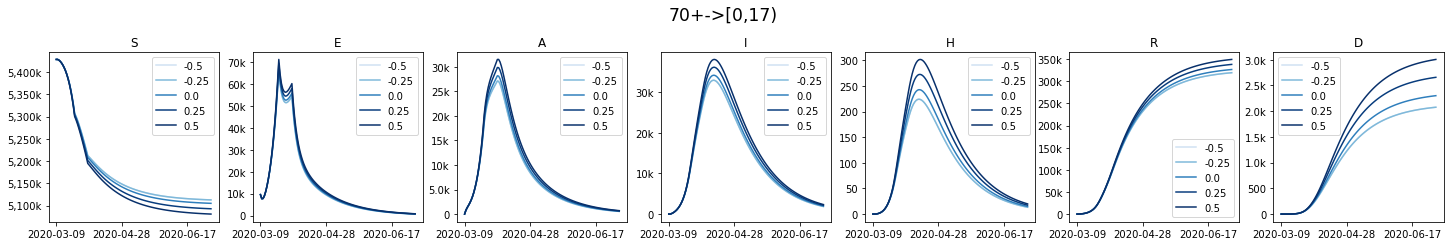

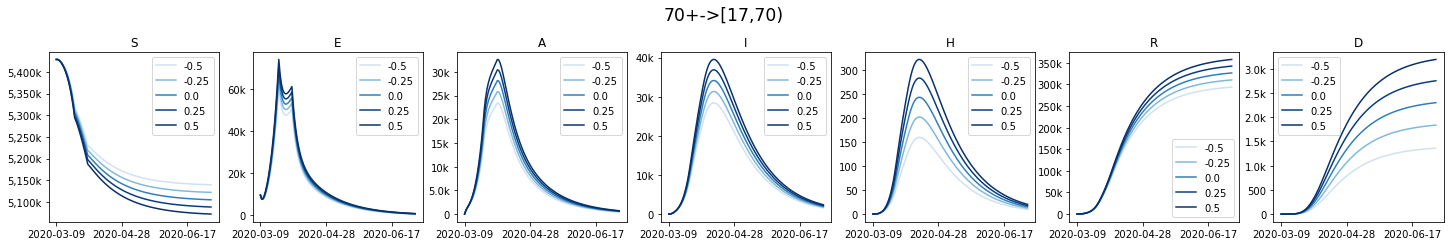

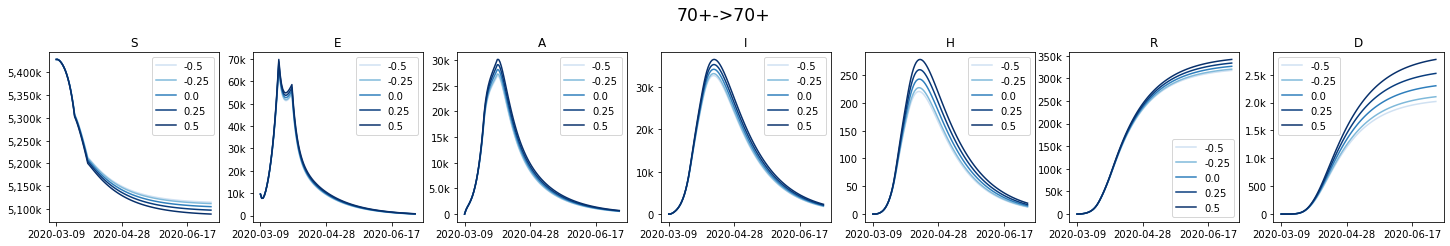

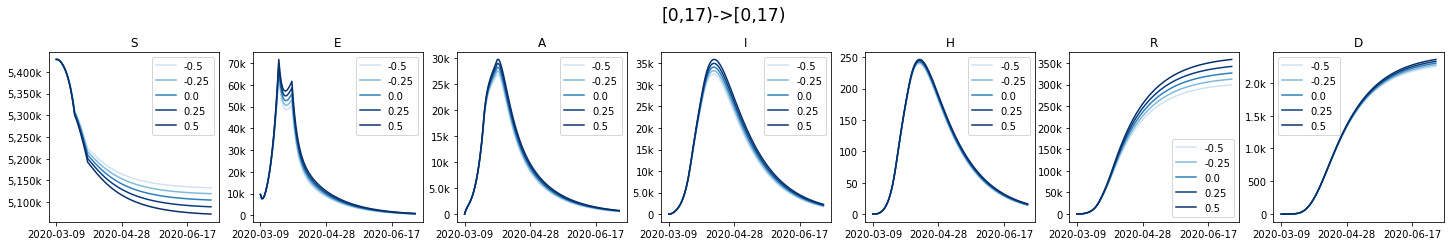

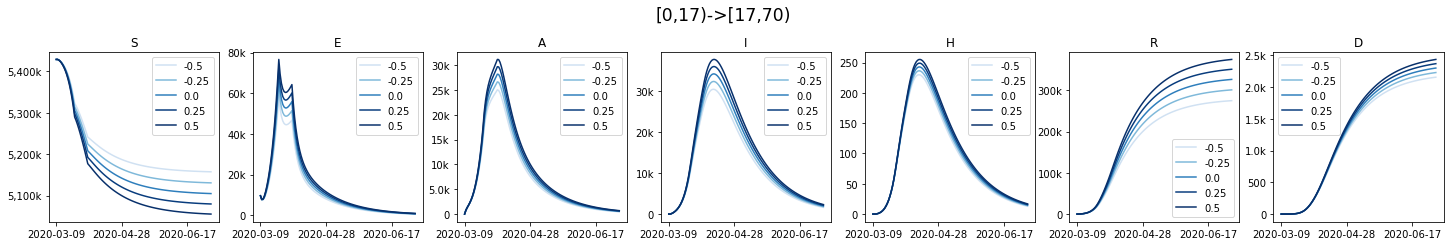

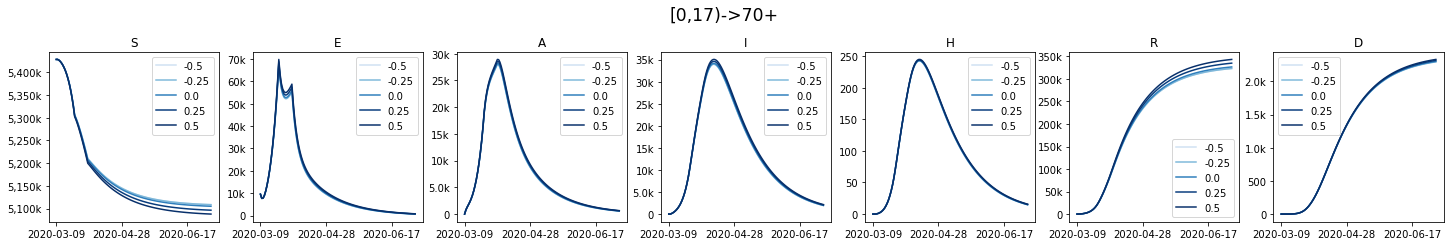

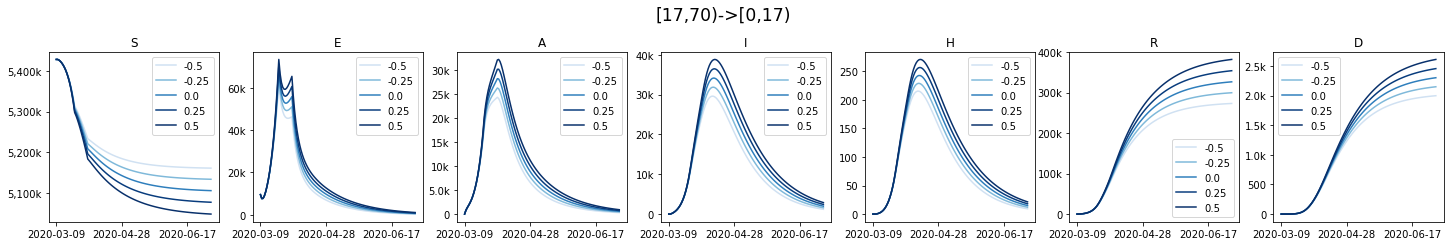

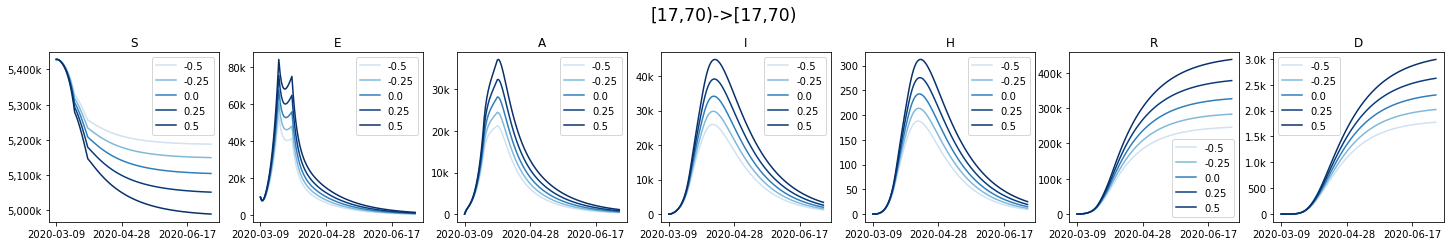

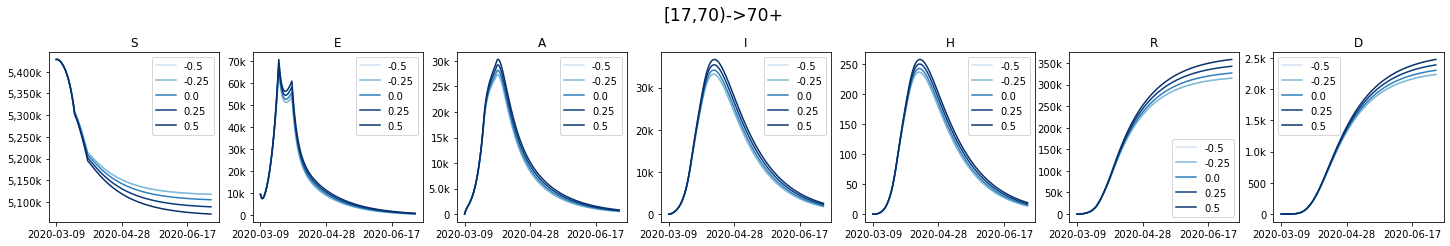

In [88]:
for age_range1, infection_row in network.mixingMatrix._matrix.items():
    for age_range2, contacts in infection_row._entries.items():
        
        fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(25, 3.5), sharex=True)
        fig.suptitle(f"{age_range1}->{age_range2}", fontsize='xx-large')
        fig.subplots_adjust(top=0.8)
        
        for bump in [-0.5, -0.25, 0., 0.25, 0.5]:
            infectionMatrix = bump_infection_matrix(age_range1, age_range2, bump)
            bumped_network = create_network(mixing_matrix=infectionMatrix)
            res = runSimulation(bumped_network, random_seed, [])
            res = aggregate_all_boards(res)

            for i, col in enumerate(['S', 'E', 'A', 'I', 'H', 'R', 'D']):
                res[col].plot(ax=axes[i], title=col, label=bump, c=cm.Blues((bump + 0.7)))
                axes[i].set_xlabel('')
                axes[i].legend()
                axes[i].yaxis.set_major_formatter(fmt)

### d) Sensitivity to infection probability

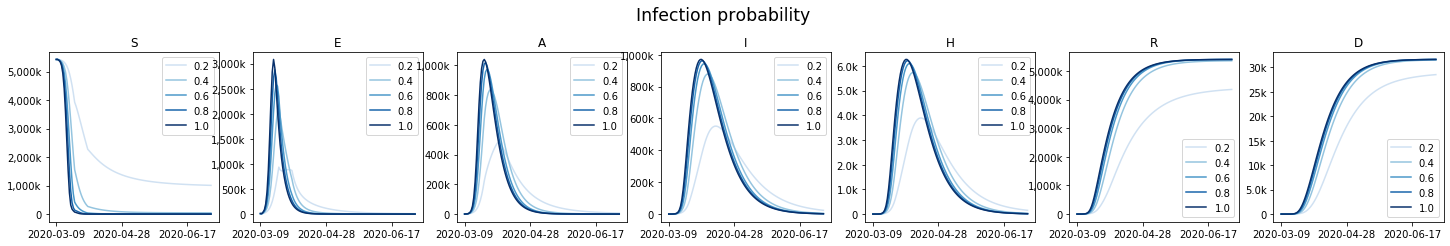

In [99]:
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(25, 3.5), sharex=True)
fig.suptitle("Infection probability", fontsize='xx-large')
fig.subplots_adjust(top=0.8)

for proba in [0.2, 0.4, 0.6, 0.8, 1.]:
    bumped_network = create_network(infection_probability=pd.DataFrame([{"Date": "2020-03-09", "Value": proba}]))
    res = runSimulation(bumped_network, random_seed, [])
    res = aggregate_all_boards(res)

    for i, col in enumerate(['S', 'E', 'A', 'I', 'H', 'R', 'D']):
        res[col].plot(ax=axes[i], title=col, label=proba, c=cm.Blues(proba))
        axes[i].set_xlabel('')
        axes[i].legend()
        axes[i].yaxis.set_major_formatter(fmt)

### e) Sensitivity to movement multipliers

Movement multiplier has little effect for small deviations, and needs to be bumped substantially before having a sizeable impact. There is not much difference in impact from a parallel change to a term structure tilt. We see that a sudden late change to the multiplier creates new waves of disease spread.

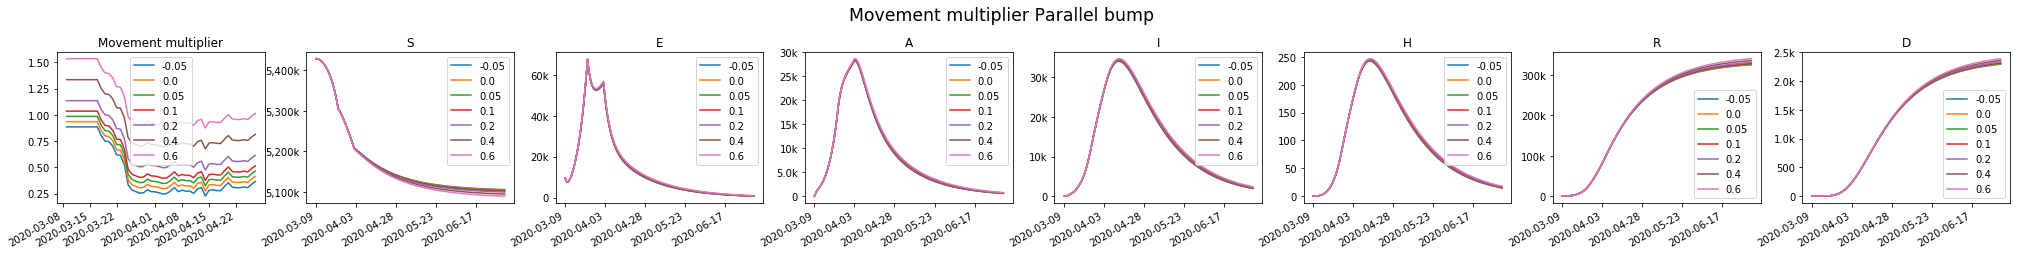

In [137]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(35, 3.5))
fig.suptitle(f"Movement multiplier Parallel bump", fontsize='xx-large')
fig.subplots_adjust(top=0.8)

for bump in [-0.05, 0., 0.05, 0.1, 0.2, 0.4, 0.6]:
    movement_multipliers = bump_movement_multipliers(bump, 0)
    bumped_network = create_network(movement_multipliers=movement_multipliers)
    res = runSimulation(bumped_network, random_seed, [])
    res = aggregate_all_boards(res)

    axes[0].plot(pd.to_datetime(movement_multipliers.Date), movement_multipliers.Movement_Multiplier, label=bump)
    axes[0].set_title("Movement multiplier")
    axes[0].set_xlabel('')
    axes[0].legend()
    
    for i, col in enumerate(['S', 'E', 'A', 'I', 'H', 'R', 'D']):
        res[col].plot(ax=axes[i + 1], title=col, label=bump)
        axes[i + 1].set_xlabel('')
        axes[i + 1].legend()
        axes[i + 1].yaxis.set_major_formatter(fmt)
        fig.autofmt_xdate()

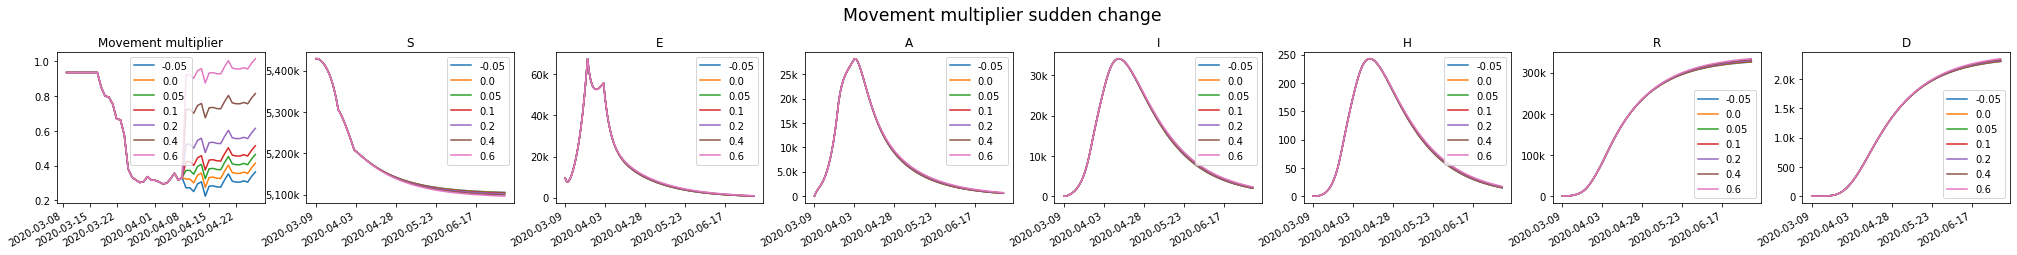

In [145]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(35, 3.5))
fig.suptitle(f"Movement multiplier sudden change", fontsize='xx-large')
fig.subplots_adjust(top=0.8)

for bump in [-0.05, 0., 0.05, 0.1, 0.2, 0.4, 0.6]:
    movement_multipliers = bump_movement_multipliers(bump, 0, dt.date(2020, 4, 9))
    bumped_network = create_network(movement_multipliers=movement_multipliers)
    res = runSimulation(bumped_network, random_seed, [])
    res = aggregate_all_boards(res)

    axes[0].plot(pd.to_datetime(movement_multipliers.Date), movement_multipliers.Movement_Multiplier, label=bump)
    axes[0].set_title("Movement multiplier")
    axes[0].set_xlabel('')
    axes[0].legend()
    
    for i, col in enumerate(['S', 'E', 'A', 'I', 'H', 'R', 'D']):
        res[col].plot(ax=axes[i + 1], title=col, label=bump)
        axes[i + 1].set_xlabel('')
        axes[i + 1].legend()
        axes[i + 1].yaxis.set_major_formatter(fmt)
        fig.autofmt_xdate()

### f) Sensitivity to contact multipliers

Contact multiplier is very impactful, even for small deviations. There is not much difference in impact from a parallel change to a term structure tilt, but we see that any sudden change up systematically creates subsequent waves.

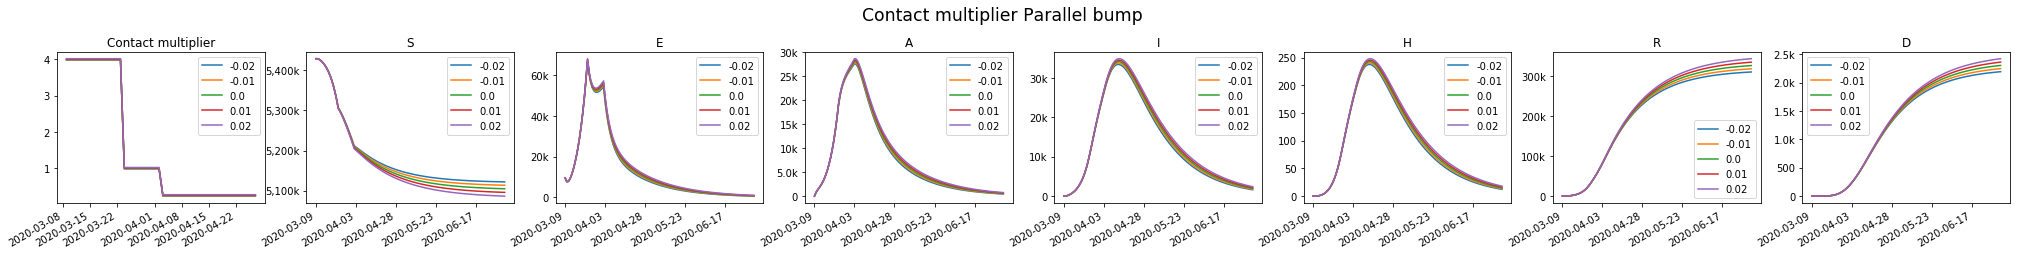

In [147]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(35, 3.5))
fig.suptitle(f"Contact multiplier Parallel bump", fontsize='xx-large')
fig.subplots_adjust(top=0.8)

for bump in [-0.02, -0.01, 0., 0.01, 0.02]:
    movement_multipliers = bump_movement_multipliers(0, bump)
    bumped_network = create_network(movement_multipliers=movement_multipliers)
    res = runSimulation(bumped_network, random_seed, [])
    res = aggregate_all_boards(res)

    axes[0].plot(pd.to_datetime(movement_multipliers.Date), movement_multipliers.Contact_Multiplier, label=bump)
    axes[0].set_title("Contact multiplier")
    axes[0].set_xlabel('')
    axes[0].legend()
    
    for i, col in enumerate(['S', 'E', 'A', 'I', 'H', 'R', 'D']):
        res[col].plot(ax=axes[i + 1], title=col, label=bump)
        axes[i + 1].set_xlabel('')
        axes[i + 1].legend()
        axes[i + 1].yaxis.set_major_formatter(fmt)
        fig.autofmt_xdate()

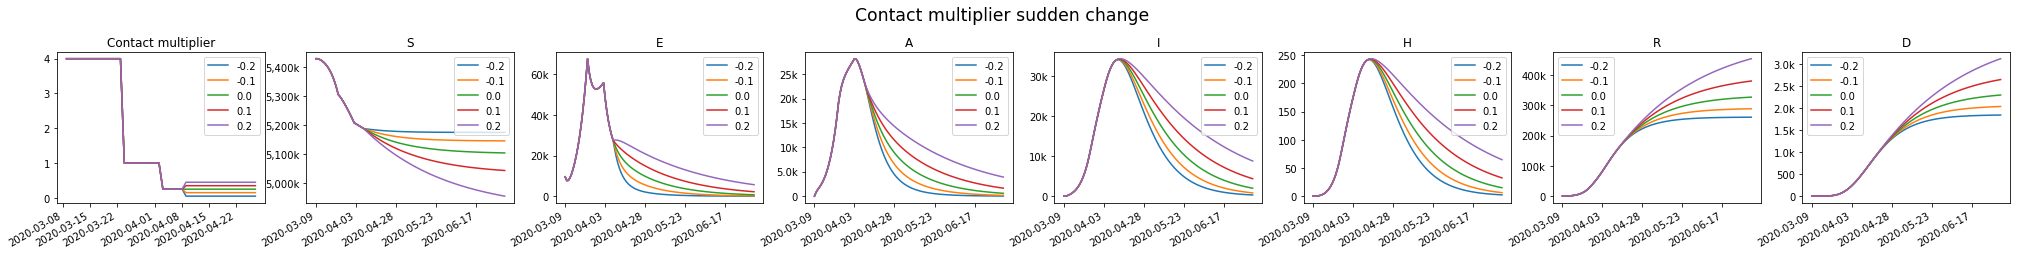

In [150]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(35, 3.5))
fig.suptitle(f"Contact multiplier sudden change", fontsize='xx-large')
fig.subplots_adjust(top=0.8)

for bump in [-0.2, -0.1, 0., 0.1, 0.2]:
    movement_multipliers = bump_movement_multipliers(0, bump, dt.date(2020, 4, 9))
    bumped_network = create_network(movement_multipliers=movement_multipliers)
    res = runSimulation(bumped_network, random_seed, [])
    res = aggregate_all_boards(res)

    axes[0].plot(pd.to_datetime(movement_multipliers.Date), movement_multipliers.Contact_Multiplier, label=bump)
    axes[0].set_title("Contact multiplier")
    axes[0].set_xlabel('')
    axes[0].legend()
    
    for i, col in enumerate(['S', 'E', 'A', 'I', 'H', 'R', 'D']):
        res[col].plot(ax=axes[i + 1], title=col, label=bump)
        axes[i + 1].set_xlabel('')
        axes[i + 1].legend()
        axes[i + 1].yaxis.set_major_formatter(fmt)
        fig.autofmt_xdate()